In [ ]:
"""  
Since this part is only realized with the ffc_2024 dataset
the following discussion is done with only the case of ffc_2024

"""

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Get the path to the parent folder of the notebook
notebook_dir = os.getcwd()  # should be 'project/notebooks'
utils_path = os.path.abspath(os.path.join(notebook_dir, '..', 'utilis'))

# Add to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

import matplotlib as mpl
import json
with open(notebook_dir + '/' + 'config.json', 'r') as f:
    loaded_settings = json.load(f)
print(loaded_settings.keys())

import matplotlib.pyplot as plt
plt.rcParams.update(loaded_settings['plot_config'])

dict_keys(['dx', 'dy', 'plot_config'])


In [ ]:
##### input #####
data_type = 's'
sample_se = '2'
selected_amp = 13
################

In [ ]:
# load the data again
import pickle
import numpy as np

save_folder_0 = f'{notebook_dir}/results_folder/'


save_folder = f'20251002_ffc_2024_{data_type}_{sample_se}' 
save_path = save_folder_0 + save_folder

### load the label data
from part5_data_loder import label_data_loader, data_loder_features
from part3_data_loader import *
from part1_data_lodaer import data_loader_ffc_2024_optimized
labels =  label_data_loader(
    data_folder_path = save_path,
    region_detetion_data_name = 'region_detection.pickle'
)

# labels_as, S, _, _=  data_loader(
#     data_folder_path = data_folder_as,
#     region_detetion_data_name = 'region_detection_2nd.pickle'
# )

### load the S
_, S = data_loader_ffc_2024_optimized(results_type='S', data_type=data_type, sample_se = sample_se)

### load the raw 3D data
# _, _, _, raw_data_3D =\
#       exp_set_loader_ffc_2024(data_type = data_type, sample_se =sample_se)

### load the similarity score
similarity_score_data_save_target = save_path + "/similarity_score.pickle"
with open(similarity_score_data_save_target, 'rb') as f:
    ss_data = pickle.load(f)

### load angular features

X_phi_data, X_o_data, X_tt_data \
    = data_loder_features(save_path)

data_metrics_phi_po_dep = X_phi_data['point_based_results']['point_based']
data_metrics_o_po_dep  = X_o_data['point_based_results']['point_based']
data_metrics_tt_po_dep  = X_tt_data['point_based_results']['point_based']

metrics_names =  X_phi_data['names']

X and S have shapes of (0,), (1525, 2)
Memory usage: X=0.0MB, S=0.0MB


In [6]:
data_sim = np.array(ss_data[13.0]['jaccard_scores'])

In [7]:
# region-dependent similarity score variation
import numpy as np

def region_funda_statistic(data, labels, selected_labels=None):
    """
    Calculate region-based statistical metrics (mean, std, median, min, max, count)
    for one or more selected labels.

    Parameters
    ----------
    data : array-like
        Numerical data for all points (shape: N,).
    labels : array-like
        Region label for each point (shape: N,).
    selected_labels : int, list, or None
        Labels to process. If None, all unique labels are used.

    Returns
    -------
    dict
        Keys: region labels
        Values: dict with 'mean', 'std', 'median', 'min', 'max', 'count'
    """
    data = np.asarray(data)
    labels = np.asarray(labels)

    if selected_labels is None:
        selected_labels = np.unique(labels)
    elif np.isscalar(selected_labels):
        selected_labels = [selected_labels]

    results = {}
    for lbl in selected_labels:
        idx = labels == lbl
        data_idx = data[idx]
        results[lbl] = {
            'mean': np.mean(data_idx),
            'std': np.std(data_idx),
            'median': np.median(data_idx),
            'min': np.min(data_idx),
            'max': np.max(data_idx),
            'count': len(data_idx)
        }

    return results

statis_data_sim = region_funda_statistic(
    data = data_sim,
    labels = labels
)
# statis_data_sim_as = region_funda_statistic(
#     data = data_sim_as,
#     labels = labels_as 
# )
print(statis_data_sim.keys())# , '\n' ,statis_data_sim_as.keys())


dict_keys([np.int32(-1), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(12), np.int32(13), np.int32(14)])


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns

def plot_region_boxplot(data, labels, ax,
                        selected_labels=None,
                        order='auto', log_scale=False,
                        show_points=True, point_kind='strip',
                        jitter=0.25, alpha=0.5,
                        notch=False,
                        ylabel='Value', xlabel='Region',
                        title=None,
                        # NEW: mean line/markers
                        show_mean=True,
                        mean_marker='o',
                        mean_linestyle='-',
                        mean_linewidth=2.0,
                        mean_markersize=6,
                        mean_zorder=6,
                        label = None):
    """
    Draw box plots of `data` grouped by `labels` into an existing matplotlib Axes,
    and overlay a line+marker for the per-region mean (aligned with category positions).
    """
    data = np.asarray(data)
    labels = np.asarray(labels)

    # Filter NaNs and optionally by selected labels
    mask = ~np.isnan(data)
    if selected_labels is not None:
        selected_labels = set(selected_labels)
        mask &= np.isin(labels, list(selected_labels))

    df = pd.DataFrame({'value': data[mask], 'region': labels[mask]})
    if df.empty:
        raise ValueError("No data to plot after filtering.")

    # Determine category order
    if isinstance(order, list):
        cat_order = order
    elif order in ('asc', 'desc'):
        med = df.groupby('region')['value'].median().sort_values()
        cat_order = med.index.tolist()
        if order == 'desc':
            cat_order = cat_order[::-1]
    else:  # 'auto' -> sort by label representation
        cat_order = sorted(df['region'].unique(), key=lambda x: (str(type(x)), x))

    # Boxplot
    sns.boxplot(
        data=df, x='region', y='value', order=cat_order,
        notch=notch, width=0.6, showfliers=True, ax=ax
    )

    # Optional raw points
    if show_points:
        if point_kind == 'swarm':
            sns.swarmplot(
                data=df, x='region', y='value', order=cat_order,
                size=3, alpha=alpha, ax=ax
            )
        else:
            sns.stripplot(
                data=df, x='region', y='value', order=cat_order,
                jitter=jitter, dodge=False, alpha=alpha, size=3, ax=ax
            )

    # Mean line + markers (aligned to categorical x positions)
    if show_mean:
        means = df.groupby('region')['value'].mean().reindex(cat_order)
        x_pos = np.arange(len(cat_order))
        ax.plot(
            x_pos, means.values,
            linestyle=mean_linestyle,
            marker=mean_marker,
            linewidth=mean_linewidth,
            markersize=mean_markersize,
            zorder=mean_zorder,
            label='Mean',
            c = 'red'
        )

    # Axis cosmetics
    if log_scale:
        ax.set_yscale('log')
    if title is not None:
        ax.set_title(title)

    if label:
        ax.text(-0.02, 1.02, f'({label})', transform=ax.transAxes, fontsize=26, 
            fontweight='bold', color='black',
            bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(bbox_to_anchor=(0.75, 1.13), loc='upper left')
    ax.grid(axis='y', linestyle='--', alpha=0.3)


In [9]:
selected_labels = statis_data_sim.keys()

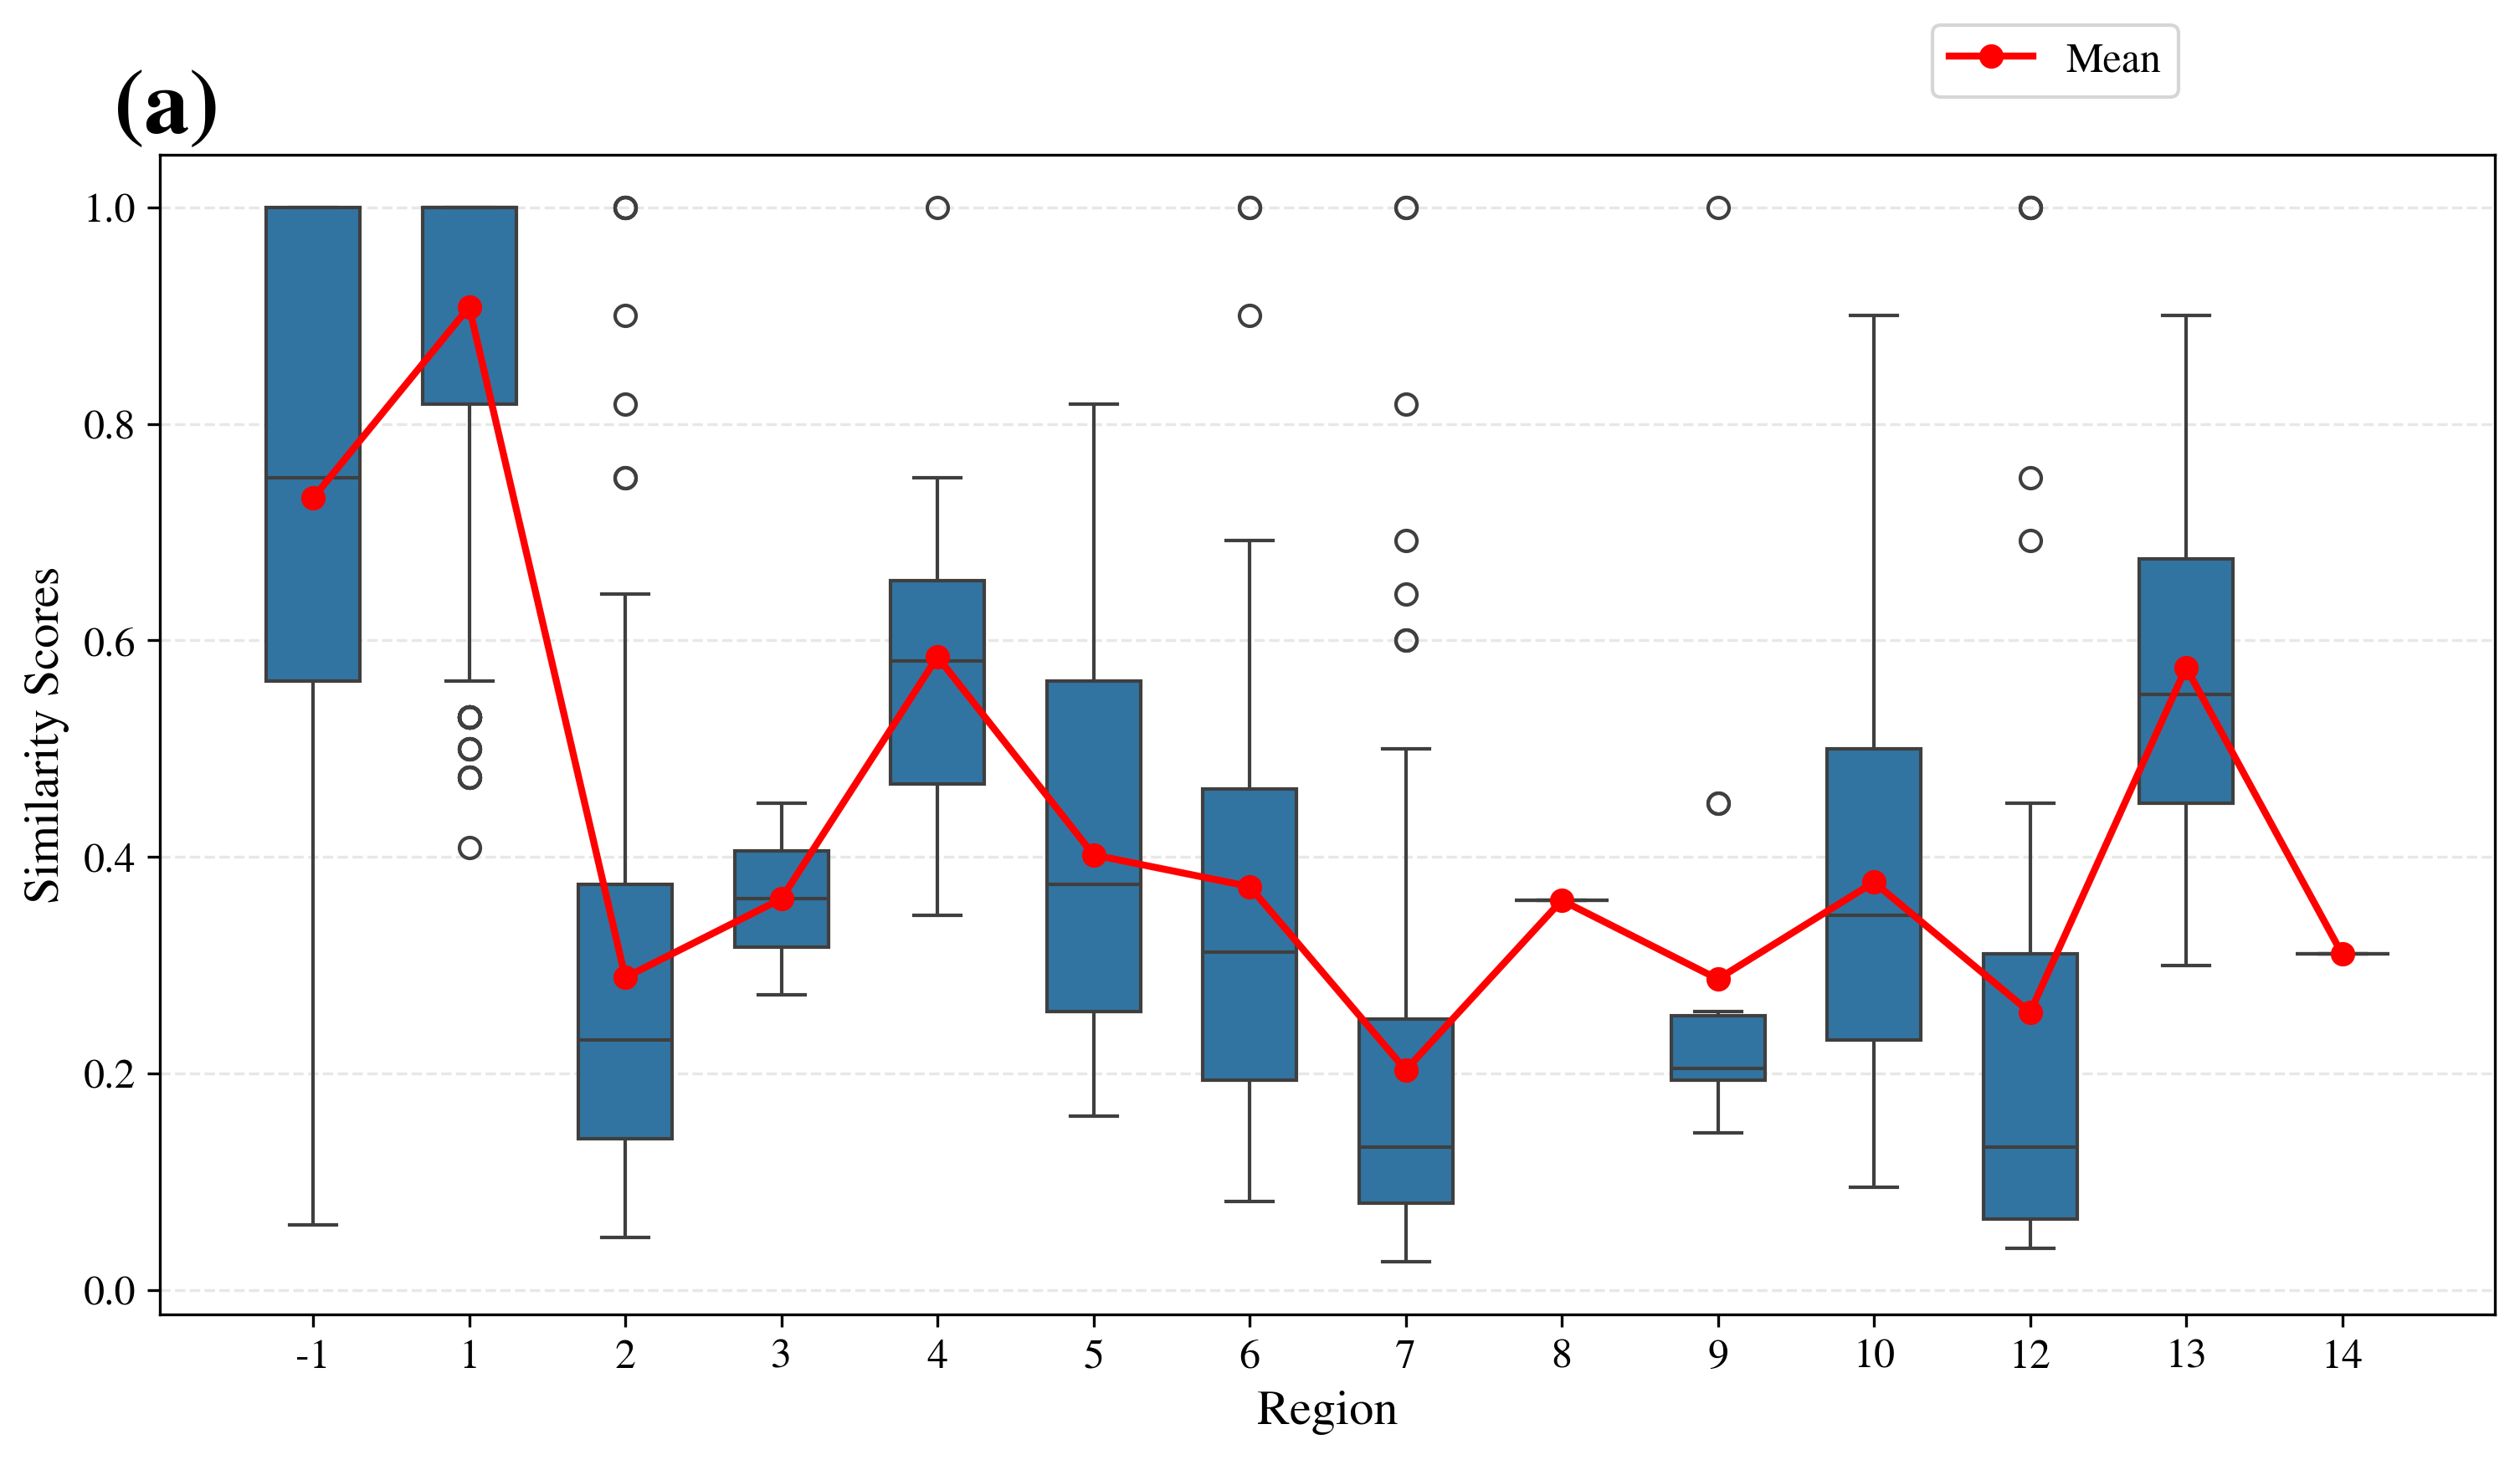

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi = 300)
plot_region_boxplot(
        ax = ax,
        data = data_sim, labels = labels, selected_labels=selected_labels,
        order='auto', ylabel='Similarity Scores',
        # title='Region-dependent Box plot',
        show_points=False,
        label = 'a'
                    )

In [12]:
## next, show the region-based plot
## at first, prepare some functions
import numpy as np

def _as_pairs_view(a: np.ndarray) -> np.ndarray:
    """
    View a float array of shape (N, 2) as a 1D structured array of pairs.
    Equality on this view is pairwise float equality (x and y must both match).
    """
    a = np.ascontiguousarray(a, dtype=np.float64)
    return a.view(np.dtype([("x", np.float64), ("y", np.float64)])).reshape(-1)

def fill_grid_by_exact_membership(S_partial, _dist_x, _dist_y, data, return_indices=False, decimals=None):
    """
    Create a rectangular grid from the extents of S_partial. For each grid node:
      - if (x,y) exists in S_partial EXACTLY (optionally after rounding to `decimals`),
        set value = data[i] where i is the index in S_partial
      - else set value = 0.

    Parameters
    ----------
    S_partial : (M, 2) array-like
    _dist_x, _dist_y : float
    data : (M,) array-like
    return_indices : bool, default False
        If True, also return (P,) array of the matched index i in S_partial, else -1.
    decimals : int or None
        If not None, round BOTH S_partial and the grid coords to this many decimals
        *before* matching, to avoid floating point dust. (No snapping to the lattice origin.)

    Returns
    -------
    grid_array : (P, 3) ndarray  [X_grid, Y_grid, value]
    idx_used   : (P,) int array (only if return_indices=True)
    """
    S_partial = np.asarray(S_partial, dtype=np.float64)
    data = np.asarray(data, dtype=np.float64)

    if S_partial.ndim != 2 or S_partial.shape[1] != 2:
        raise ValueError("S_partial must have shape (M, 2).")
    if data.shape != (S_partial.shape[0],):
        raise ValueError("data must have shape (M,) aligned with S_partial.")
    if _dist_x <= 0 or _dist_y <= 0:
        raise ValueError("_dist_x and _dist_y must be positive.")

    X = S_partial[:, 0]
    Y = S_partial[:, 1]

    # 1) Extents and grid sizes
    X_min, X_max = float(np.min(X)), float(np.max(X))
    Y_min, Y_max = float(np.min(Y)), float(np.max(Y))
    n_x = int(np.round((X_max - X_min) / _dist_x)) + 1
    n_y = int(np.round((Y_max - Y_min) / _dist_y)) + 1
    if n_x <= 0 or n_y <= 0:
        raise ValueError("Computed grid has non-positive size; check inputs.")

    # 2) Build the rectangular grid
    xs = X_min + np.arange(n_x) * _dist_x
    ys = Y_min + np.arange(n_y) * _dist_y
    Xg, Yg = np.meshgrid(xs, ys, indexing="xy")            # shapes (n_y, n_x)
    P = n_x * n_y
    G = np.column_stack([Xg.ravel(), Yg.ravel()])          # (P, 2)

    # 3) Optional rounding (to tame float dust), but NOT snapping to any origin
    if decimals is not None:
        S_match = np.round(S_partial, decimals=decimals)
        G_match = np.round(G, decimals=decimals)
    else:
        S_match = S_partial
        G_match = G

    # 4) Exact pairwise membership via structured-array intersection
    S_pairs = _as_pairs_view(S_match)                      # (M,)
    G_pairs = _as_pairs_view(G_match)                      # (P,)

    # Find common (x,y) pairs and the indices where they occur
    # idx_S: indices into S_partial; idx_G: indices into the grid G
    _, idx_S, idx_G = np.intersect1d(S_pairs, G_pairs, return_indices=True)

    # 5) Fill values: default 0, overwrite where matched
    values = np.zeros(P, dtype=np.float64)
    values[idx_G] = data[idx_S]

    grid_array = np.column_stack([G[:, 0], G[:, 1], values])

    if return_indices:
        idx_used = np.full(P, -1, dtype=int)
        idx_used[idx_G] = idx_S
        return grid_array, idx_used, n_x, n_y
    return grid_array, n_x, n_y


from matplotlib.tri import Triangulation
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.path import Path
from scipy.spatial.distance import cdist
from function import extract_area_boundaries, indices_of_s_in_S


def plot_areas(ax, S, data, labels, selected_label,
               title=None, _to_be_rectangle_flag=True,
               _dist_x=5, _dist_y=5, decimals=2, 
               method='masked_tricontourf', 
               max_triangle_size=None,
               label=None,
               color_bar_title = None,
               z_range=None):
    """
    Plot areas with arbitrary shapes, avoiding extrapolation beyond data points.
    
    Parameters:
    - method: 'masked_tricontourf', 'alpha_shape', 'nearest_neighbor', or 'tripcolor_filtered'
    - max_triangle_size: Maximum allowed triangle edge length (auto-calculated if None)
    - z_range: Tuple of (zmin, zmax) for consistent color scaling across plots
    
    Returns:
    - contour: The mappable object for colorbar creation
    """
    # mask the selected region
    idx = np.isin(labels, selected_label)

    # add the boundaries info
    boundaries, _ = extract_area_boundaries(
            points=S,
            step_x=_dist_x, step_y=_dist_y, 
            labels=labels, target_labels=selected_label,
            plot=False
        )
    X_bounds = boundaries[:, 0]
    Y_bounds = boundaries[:, 1]
    area_bounds_idx = indices_of_s_in_S(S, boundaries)
    idx = np.hstack([((np.where(idx)[0]).astype(int)), np.array(area_bounds_idx)])
    S_to_plot = S[idx]
    X = S_to_plot[:, 0]
    Y = S_to_plot[:, 1]
    Z = data[idx]
    
    X_scatter = X.copy()
    Y_scatter = Y.copy()

    if _to_be_rectangle_flag:
        modified_grid_array, n_x, n_y = fill_grid_by_exact_membership(
                S_partial=S_to_plot,
                _dist_x=_dist_x,
                _dist_y=_dist_y,
                data=Z,
                decimals=decimals
            )
        X_grid = modified_grid_array[:, 0]
        Y_grid = modified_grid_array[:, 1]
        Z_grid = modified_grid_array[:, 2]
    else:
        X_grid, Y_grid, Z_grid = X, Y, Z

    # drop NaNs and zeros for clean triangulation
    m = np.isfinite(X_grid) & np.isfinite(Y_grid) & np.isfinite(Z_grid) & (Z_grid != 0)
    X_clean, Y_clean, Z_clean = X_grid[m], Y_grid[m], Z_grid[m]

    # Calculate color limits
    if z_range is None:
        if X_clean.size >= 3:
            zmin, zmax = float(np.min(Z_clean)), float(np.max(Z_clean))
        else:
            Z_nonzero = Z[Z != 0]
            zmin, zmax = (float(np.min(Z_nonzero)), float(np.max(Z_nonzero))) if Z_nonzero.size > 0 else (0, 1)
    else:
        zmin, zmax = z_range
        
    if zmin == zmax:
        eps = abs(zmin) * 1e-6 if zmin != 0 else 1e-6
        zmin, zmax = zmin - eps, zmax + eps

    # Fallback to scatter if insufficient points
    if X_clean.size < 3:
        contour = ax.scatter(X_scatter, Y_scatter, 
                           c=Z[Z != 0] if np.any(Z != 0) else [0], 
                           cmap='viridis', s=20, vmin=zmin, vmax=zmax)
        # Add cosmetics
        if title:
            ax.set_title(title)
        ax.set_xlabel(r'X [$\mu$m]')
        ax.set_ylabel(r'Y [$\mu$m]')
        ax.set_aspect('equal')
        if label:
            ax.text(-0.13, 1.05, f'({label})', transform=ax.transAxes, fontsize=26, 
                    fontweight='bold', color='black',
                    bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        return contour

    if method == 'masked_tricontourf':
        tri = Triangulation(X_clean, Y_clean)
        
        if max_triangle_size is None:
            distances = cdist(np.column_stack([X_clean, Y_clean]), 
                            np.column_stack([X_clean, Y_clean]))
            distances[distances == 0] = np.inf
            avg_nn_dist = np.mean(np.min(distances, axis=1))
            max_triangle_size = avg_nn_dist * 2.5
        
        triangles = tri.triangles
        edge_lengths = []
        for triangle in triangles:
            p1, p2, p3 = triangle
            edges = [
                np.sqrt((X_clean[p1] - X_clean[p2])**2 + (Y_clean[p1] - Y_clean[p2])**2),
                np.sqrt((X_clean[p2] - X_clean[p3])**2 + (Y_clean[p2] - Y_clean[p3])**2),
                np.sqrt((X_clean[p3] - X_clean[p1])**2 + (Y_clean[p3] - Y_clean[p1])**2)
            ]
            edge_lengths.append(max(edges))
        
        mask = np.array(edge_lengths) < max_triangle_size
        tri.set_mask(~mask)
        
        levels = np.linspace(zmin, zmax, 29)
        contour = ax.tricontourf(tri, Z_clean, levels=levels, cmap='viridis', extend='both')
        
    elif method == 'alpha_shape':
        try:
            hull = ConvexHull(np.column_stack([X_clean, Y_clean]))
            hull_path = Path(np.column_stack([X_clean, Y_clean])[hull.vertices])
            
            tri = Triangulation(X_clean, Y_clean)
            triangle_centroids = []
            for triangle in tri.triangles:
                cx = np.mean(X_clean[triangle])
                cy = np.mean(Y_clean[triangle])
                triangle_centroids.append([cx, cy])
            triangle_centroids = np.array(triangle_centroids)
            
            inside_mask = hull_path.contains_points(triangle_centroids)
            tri.set_mask(~inside_mask)
            
            levels = np.linspace(zmin, zmax, 29)
            contour = ax.tricontourf(tri, Z_clean, levels=levels, cmap='viridis', extend='both')
            
        except:
            return plot_areas(ax, S, data, labels, selected_label, title, 
                            _to_be_rectangle_flag, _dist_x, _dist_y, decimals, 
                            'masked_tricontourf', max_triangle_size, label, z_range)
    
    elif method == 'tripcolor_filtered':
        tri = Triangulation(X_clean, Y_clean)
        
        if max_triangle_size is None:
            distances = cdist(np.column_stack([X_clean, Y_clean]), 
                            np.column_stack([X_clean, Y_clean]))
            distances[distances == 0] = np.inf
            avg_nn_dist = np.mean(np.min(distances, axis=1))
            max_triangle_size = avg_nn_dist * 2.0
        
        triangles = tri.triangles
        edge_lengths = []
        for triangle in triangles:
            p1, p2, p3 = triangle
            edges = [
                np.sqrt((X_clean[p1] - X_clean[p2])**2 + (Y_clean[p1] - Y_clean[p2])**2),
                np.sqrt((X_clean[p2] - X_clean[p3])**2 + (Y_clean[p2] - Y_clean[p3])**2),
                np.sqrt((X_clean[p3] - X_clean[p1])**2 + (Y_clean[p3] - Y_clean[p1])**2)
            ]
            edge_lengths.append(max(edges))
        
        mask = np.array(edge_lengths) < max_triangle_size
        tri.set_mask(~mask)
        
        contour = ax.tripcolor(tri, Z_clean, cmap='viridis', shading='gouraud', 
                              vmin=zmin, vmax=zmax)
    
    else:  # nearest_neighbor
        contour = ax.scatter(X_clean, Y_clean, c=Z_clean, 
                           cmap='viridis', s=50, alpha=0.8,
                           vmin=zmin, vmax=zmax)

    # Add original data points as small black dots for reference
    ax.scatter(X_scatter, Y_scatter, s=4.5, c='black', alpha=0.5, zorder=10)
    ax.scatter(X_bounds, Y_bounds, s=15, c='red', alpha=0.5, zorder=10)

    # set the colorbar if needed
    # here try a horizontally oriented color bar with only min, max and the median
    if z_range == None:
        cbar = plt.colorbar(contour, ax=ax, orientation="horizontal"
                            , shrink=0.7,  # Make colorbar 60% of axes width
                            aspect=30,    # Control thickness
                            pad=0.137
                            )
        zmid = (zmin + zmax) / 2
        cbar.set_ticks([zmin, zmid, zmax])
    else:
        print('Set the colorbar alone please!')

    # set the title of the colorbar
    if color_bar_title:
        cbar.set_label(fr'{color_bar_title}')
    else:
        cbar.set_label(r'[$\degree$]')

    # labels & cosmetics
    if title:
        ax.set_title(title)
    ax.set_xlabel(r'X [$\mu$m]')
    ax.set_ylabel(r'Y [$\mu$m]')
    ax.set_aspect('equal')

    if label:
        ax.text(-0.13, 1.097, f'({label})', transform=ax.transAxes, fontsize=26, 
                fontweight='bold', color='black',
                bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

    return contour



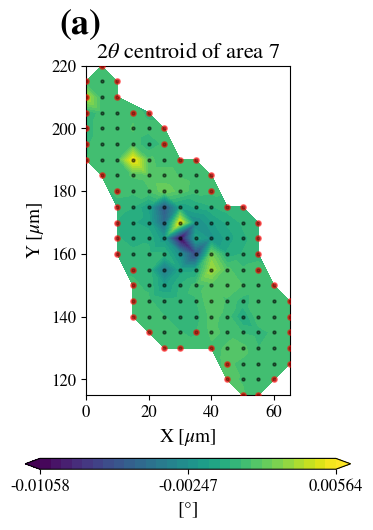

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

z_range = [-0.02, 0.02]
contour = plot_areas(
    ax=ax,
    S=S, 
    data=data_metrics_tt_po_dep['moment_differences.centroid_diff'],
    labels=labels, 
    selected_label=7,
    title=r'2$\theta$ centroid of area 7',
    color_bar_title = None,
    _to_be_rectangle_flag=True,
    label='a',
    # z_range=z_range
)

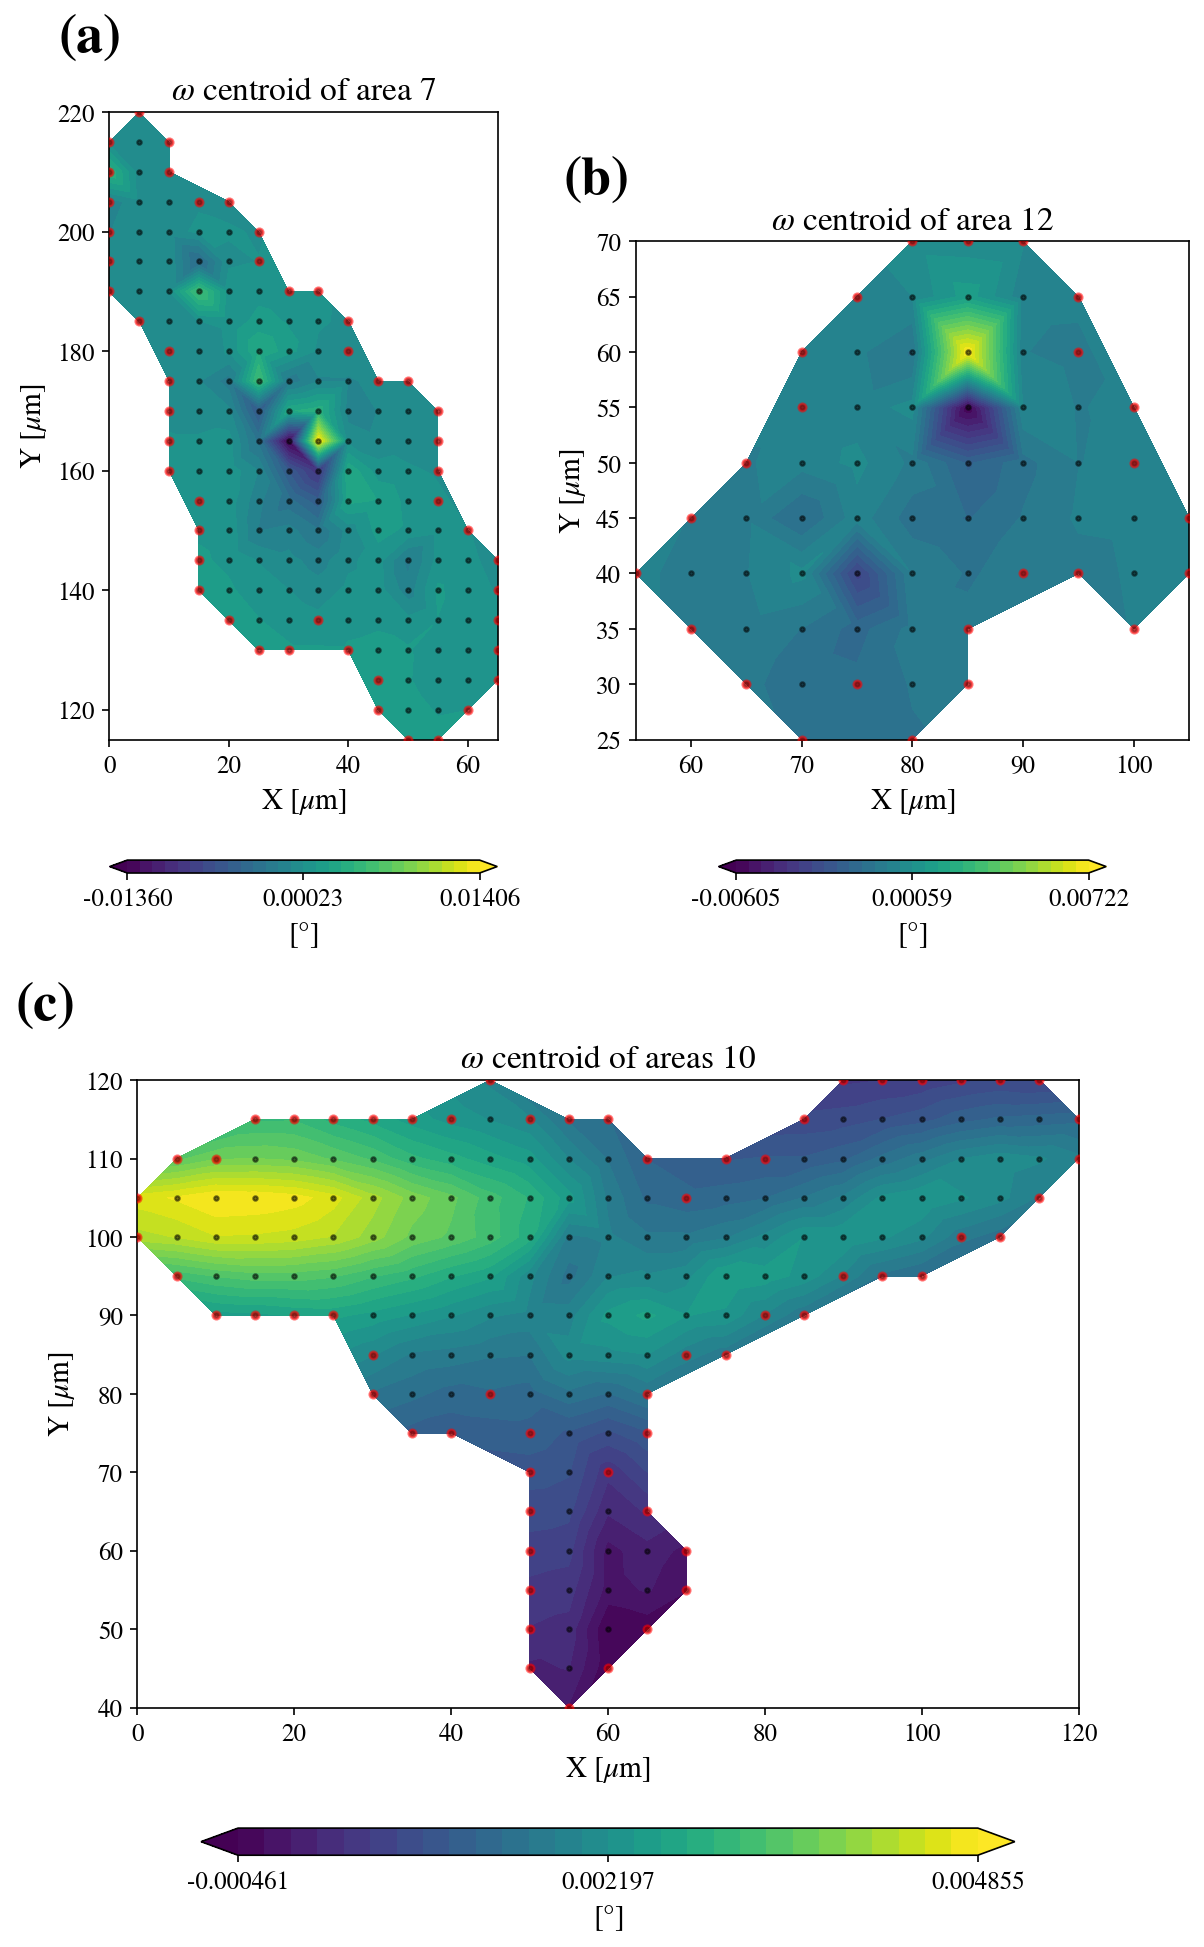

In [14]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.gridspec as gridspec

# Define areas information
areas_info = [
    {'labels': labels, 'selected_label': 7},
    {'labels': labels, 'selected_label': 12},
    {'labels': labels, 'selected_label': 10}
]

# Calculate z_range automatically

# Create figure with GridSpec
fig = plt.figure(figsize=(10, 16), dpi=150) # 10， 15/18
gs = gridspec.GridSpec(2, 2, figure=fig
                       , width_ratios=[1, 1]
                       , height_ratios=[1, 1]
                       , wspace=0.1, hspace=0.1)

# Create axes
axes1 = fig.add_subplot(gs[0, 0])
axes2 = fig.add_subplot(gs[0, 1])
axes3 = fig.add_subplot(gs[1, :2])

selected_labeles_ls = [7, 12, 10]

# Plot all areas with consistent z_range
plot_areas(
    ax=axes1,
    S=S, 
    data=data_metrics_o_po_dep['moment_differences.centroid_diff'],
    labels=labels, 
    selected_label=selected_labeles_ls[0],
    title=rf'$\omega$ centroid of area {selected_labeles_ls[0]}',
    label='a',
    _to_be_rectangle_flag=True,
)

plot_areas(
    ax=axes2,
    S=S, 
    data=data_metrics_o_po_dep['moment_differences.centroid_diff'],
    labels=labels, 
    selected_label=selected_labeles_ls[1],
    title=rf'$\omega$ centroid of area {selected_labeles_ls[1]}',
    _to_be_rectangle_flag=True,
    label='b',
)

plot_areas(
    ax=axes3,
    S=S, 
    data=data_metrics_o_po_dep['moment_differences.centroid_diff'],
    labels=labels, 
    selected_label=selected_labeles_ls[2],
    title=rf'$\omega$ centroid of areas {selected_labeles_ls[2]}',
    _to_be_rectangle_flag=True,
    label='c',
)

# Single shared colorbar
plt.show()